# Exponential smoothing

This is one subject where python code lags far behind that available in R.

We will use a simple implementation from the following series of pages by Grisha Trubetskoy:  
https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/  
https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/  
https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/  

These also contain a good explanation of the algorithm.  

This code has one important error: at time n, you can only use input data up to time <= n-1!
(We fix this for simple_exponential_smoothing)

This notebook adds plots & interactivity, but so far is only quick&dirty experimental code

For more extensive use, you would want to work with these in python time series, rather than just in arrays.  

In [18]:
#imports - not needed for basic exponential smoothing commands
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## Part I: Simple exponential smoothing without trend
We start with sample data and illustrative functions.   
Compared to original code, series2 is renaming of series, and series3 is new.

In [4]:
series = [3,10,12,13,12,10,12]

In [52]:
#sinusoidal without evident trend
series2 = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

#sinusoidal + quadratic trend
series3 = [series2[i]+i**2/50 for i in range(len(series2))]

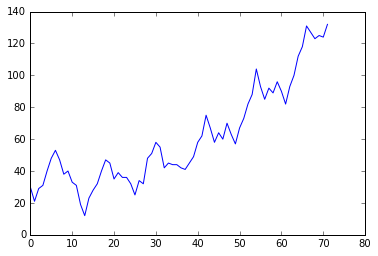

In [84]:
plt.plot(series3)

### The following four functions are not needed - they just illustrate weighted averages.
Exponential smooting uses 'exponentally' weighted averages

In [5]:
def average(series):
    return float(sum(series))/len(series)

# Given the above series, the average is:
# >>> average(series)
# 10.285714285714286

In [6]:
# moving average using n last points
def moving_average(series, n):
    return average(series[-n:])

# >>> moving_average(series, 3)
# 11.333333333333334
# >>> moving_average(series, 4)
# 11.75

In [7]:
# moving average if n given, average of all otherwise
def average(series, n=None):
    if n is None:
        return average(series, len(series))
    return float(sum(series[-n:]))/n

# >>> average(series, 3)
# 11.333333333333334
# >>> average(series)
# 10.285714285714286

In [6]:
# weighted average, weights is a list of weights
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

# >>> weights = [0.1, 0.2, 0.3, 0.4]
# >>> weighted_average(series, weights)
# 11.5

### The simplest exponential smoothing model just weights the latest value against the prior model.  
The single parameter $\alpha$ (alpha in code) says how heavily to weight the latest value.

In [85]:
# given a series and alpha, return series of smoothed points
#slight correction here: result lags series in availability of information. 
def exponential_smoothing(series, alpha):
    result = [series[0], series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# >>> exponential_smoothing(series, 0.1)
# [3,3, 3.7, 4.53, 5.377, 6.0393, 6.43537, 6.991833]
# >>> exponential_smoothing(series, 0.9)
# [3,3, 9.3, 11.73, 12.873000000000001, 12.0873, 10.20873, 11.820873]

In [76]:
exponential_smoothing(series, 0.9)

[3, 3, 9.3, 11.100000000000001, 12.63, 11.91, 10.263, 11.991]

In [86]:
def plotSimple(alpha):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(data)
    ax.plot(exponential_smoothing(data, alpha), label = "alpha=" + str(alpha))
    ax.legend(loc='best', prop={'size':'large'})

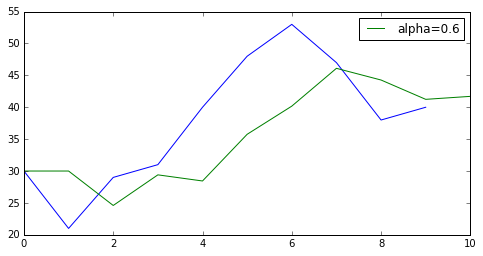

In [87]:
#caution: this "cheats" for alpha=1: lag of 1 disappears
data = series3[:10]
interact(plotSimple, alpha=widgets.FloatSlider(min=0.0,max=1.0,step=.1,value=.5))

## Part II: Exponential smoothing with level and trend

Now in addition to maintaining parameter $\alpha$, the second parameter $\beta$ ("beta" in code) says how much to weight the latest increase against the historical model of increase.

In [37]:
# given a series and alpha, return series of smoothed points
# Need to fix error: result[n] can only use information from series up to index n-1
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

# >>> double_exponential_smoothing(series, alpha=0.9, beta=0.9)
# [3, 17.0, 15.45, 14.210500000000001, 11.396044999999999, 8.183803049999998, 12.753698384500002, 13.889016464000003]

In [57]:
double_exponential_smoothing(series, alpha=0.9, beta=0.9);

In [88]:
def plotDouble(alpha, beta):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(data)
    ax.plot(double_exponential_smoothing(data, alpha, beta), label = "alpha=%s, beta=%s" % (str(alpha), str(beta)) )
    ax.legend(loc='best', prop={'size':'large'})

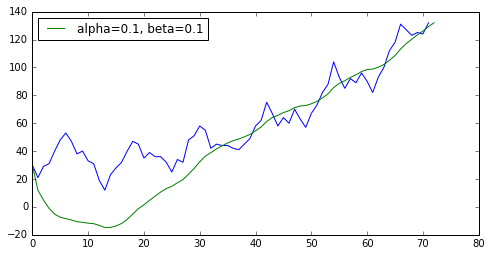

In [89]:
#interesting interaction: series3, alpha=.1, beta=0: beta gets hijacked by first value
data = series3
interact(plotDouble, 
         alpha=widgets.FloatSlider(min=0.0,max=1.0,step=.1,value=.5),
         beta=widgets.FloatSlider(min=0.0,max=1.0,step=.1,value=.5))

## Part III: Adding seasonality to level and trend
  
"Triple" exponential smoothing maintains 'slen' 'seasonality' coefficients in addition to models for level and trend.
This many seasonal differences are created from the first slen values, and are then updated over time.

In [61]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

# >>> initial_trend(series2, 12)
# -0.7847222222222222

In [59]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

# >>> initial_seasonal_components(series2, 12)
# {0: -7.4305555555555545, 1: -15.097222222222221, 2: -7.263888888888888, 3: -5.097222222222222, 4: 3.402777777777778, 5: 8.069444444444445, 6: 16.569444444444446, 7: 9.736111111111112, 8: -0.7638888888888887, 9: 1.902777777777778, 10: -3.263888888888889, 11: -0.7638888888888887}

In [60]:
initial_seasonal_components(series2, 12);

In [63]:
#Unlike the prior two versions, this one allows you to specify how far out to forecast (n_preds)
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# # forecast 24 points (i.e. two seasons)
# >>> triple_exponential_smoothing(series2, 12, 0.716, 0.029, 0.993, 24)
# [30, 20.34449316666667, 28.410051892109554, 30.438122252647577, 39.466817731253066, ...

In [64]:
triple_exponential_smoothing(series2, 12, 0.716, 0.029, 0.993, 24)[:6];

In [71]:
#Bad code: hard-codes seasonal length as 12 and forecast horizon as 36 (=3 seasons)
def plotTriple(alpha, beta, gamma):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(data)
    ax.plot(triple_exponential_smoothing(data, 12, alpha, beta, gamma, 36), label = "alpha=%s\nbeta=%s\ngamma=%s" % (str(alpha), str(beta), str(gamma)) )
    ax.legend(loc='best', prop={'size':'large'})

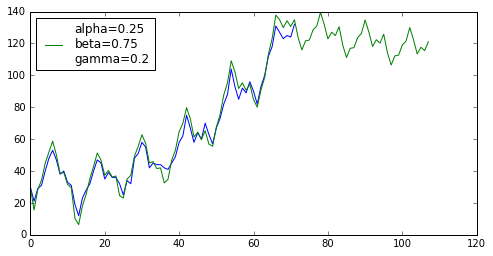

In [72]:
#Hard-coded to forecast three years out. 
#Notice robustness of model to (non-extreme) values of parameters
#beta is susceptible to extremes.
data = series3
interact(plotTriple, 
         alpha=widgets.FloatSlider(min=0.0,max=1.0,step=.25,value=.5),
         beta=widgets.FloatSlider(min=0.0,max=1.0,step=.25,value=.5),
         gamma=widgets.FloatSlider(min=0.0,max=1.0,step=.1,value=.5))

...back to main presentation